# 📦 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
import pickle

# 🖋️ Load Custom Font
font_path = './fonts/NotoSansDevanagari-VariableFont_wdth,wght.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans Devanagari'


# 📂 Load Data

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [4]:
df.shape

(92000, 1025)

In [5]:
df.groupby("character").size()

character
character_01_ka              2000
character_02_kha             2000
character_03_ga              2000
character_04_gha             2000
character_05_kna             2000
character_06_cha             2000
character_07_chha            2000
character_08_ja              2000
character_09_jha             2000
character_10_yna             2000
character_11_taamatar        2000
character_12_thaa            2000
character_13_daa             2000
character_14_dhaa            2000
character_15_adna            2000
character_16_tabala          2000
character_17_tha             2000
character_18_da              2000
character_19_dha             2000
character_20_na              2000
character_21_pa              2000
character_22_pha             2000
character_23_ba              2000
character_24_bha             2000
character_25_ma              2000
character_26_yaw             2000
character_27_ra              2000
character_28_la              2000
character_29_waw             2000
char

# 🔍 Filter Selected Characters

In [6]:
selected_characters = [
    'character_01_ka', 'character_02_kha', 'character_03_ga', 'character_04_gha', 'character_05_kna',
    'character_06_cha', 'character_07_chha', 'character_08_ja', 'character_09_jha', 'character_10_yna'
]
filtered_df = df[df["character"].isin(selected_characters)]

# 🔤 Map Labels to Devanagari

In [7]:
map_dict = {
    'character_01_ka': 'क', 'character_02_kha': 'ख', 'character_03_ga': 'ग','character_04_gha': 'घ',
    'character_05_kna': 'ङ', 'character_06_cha': 'च', 'character_07_chha': 'छ', 'character_08_ja': 'ज',
    'character_09_jha': 'झ','character_10_yna': 'ञ'
}
filtered_df.loc[:, 'character'] = filtered_df['character'].map(map_dict)

# 📊 Display Sample Images

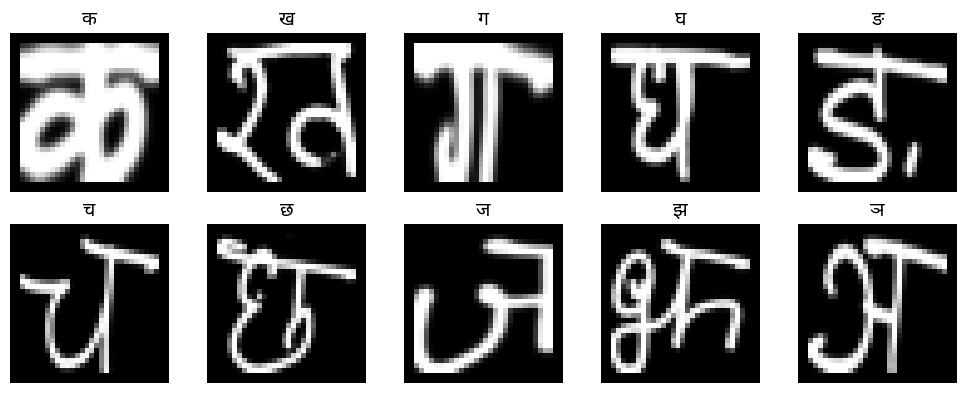

In [8]:
unique_features = filtered_df['character'].unique()
num_class = len(unique_features)
cols, rows = 5, math.ceil(num_class / 5)
plt.figure(figsize=(cols * 2, rows * 2))
for i, character in enumerate(unique_features):
    subset = filtered_df[filtered_df['character'] == character]
    if subset.empty:
        continue
    sample_row = subset.iloc[0]
    image = sample_row.drop('character').values.astype(np.float32).reshape(32, 32)
    plt.subplot(rows, cols, i + 1)
    plt.title(character, fontsize=14)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

# 🧹 Check for Nulls and Duplicates

In [9]:
print("Null values:", filtered_df.isnull().sum().sum())
print("Duplicate rows:", filtered_df.duplicated().sum())


Null values: 0
Duplicate rows: 0


# 🧪 Split Data into Train and Test

In [10]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for character in unique_features:
    char_df = filtered_df[filtered_df['character'] == character]
    train_char, test_char = train_test_split(char_df, test_size=0.2, random_state=42)
    train_df = pd.concat([train_df, train_char], ignore_index=True)
    test_df = pd.concat([test_df, test_char], ignore_index=True)

# 📐 Prepare Features and Labels

In [11]:
X_train = train_df.drop('character', axis=1).values
X_test = test_df.drop('character', axis=1).values
y_train = train_df['character'].values
y_test = test_df['character'].values

X_train_flat = X_train.astype('float32') / 255.0
X_test_flat = X_test.astype('float32') / 255.0

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping: {'क': 0, 'ख': 1, 'ग': 2, 'घ': 3, 'ङ': 4, 'च': 5, 'छ': 6, 'ज': 7, 'झ': 8, 'ञ': 9}


# 🌳 Train Random Forest

In [12]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_encoded)
y_pred = rf_model.predict(X_test_flat)
y_pred_labels = le.inverse_transform(y_pred)

# 📈 Evaluation: Random Forest

Random Forest Accuracy: 0.9455
              precision    recall  f1-score   support

           क       0.96      0.97      0.97       400
           ख       0.90      0.96      0.93       400
           ग       0.95      0.93      0.94       400
           घ       0.89      0.95      0.92       400
           ङ       0.94      0.94      0.94       400
           च       0.96      0.95      0.96       400
           छ       0.96      0.89      0.92       400
           ज       0.96      0.94      0.95       400
           झ       0.98      0.96      0.97       400
           ञ       0.96      0.95      0.95       400

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



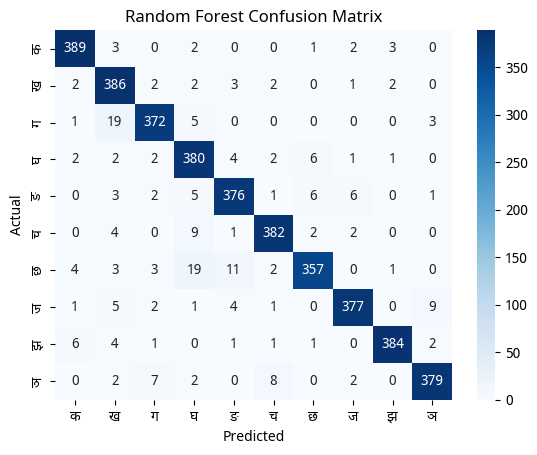

In [13]:
print("Random Forest Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
cm_rf = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# 📦 PCA + SVM Classification and t-SNE Visualization

## ⏬ Reduce features to 100 components using PCA (helps SVM speed and performance)

In [14]:
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# 🧪 Train SVM model on PCA-transformed data

In [15]:
svm_model = SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=42)
svm_model.fit(X_train_pca, y_train_encoded)

SVC(C=10, gamma=0.01, probability=True, random_state=42)

# 📊 Evaluate SVM on test data

In [16]:
y_pred_svm = svm_model.predict(X_test_pca)
print("🔍 [SVM] Accuracy:", accuracy_score(y_test_encoded, y_pred_svm))
print("🔍 [SVM] Classification Report:\n", classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_))


🔍 [SVM] Accuracy: 0.982
🔍 [SVM] Classification Report:
               precision    recall  f1-score   support

           क       0.98      0.98      0.98       400
           ख       0.98      0.98      0.98       400
           ग       0.98      0.99      0.99       400
           घ       0.98      0.98      0.98       400
           ङ       0.98      0.97      0.98       400
           च       0.99      0.99      0.99       400
           छ       0.98      0.97      0.98       400
           ज       0.97      0.98      0.98       400
           झ       0.99      0.99      0.99       400
           ञ       0.98      0.98      0.98       400

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



# 🧩 Confusion Matrix for SVM

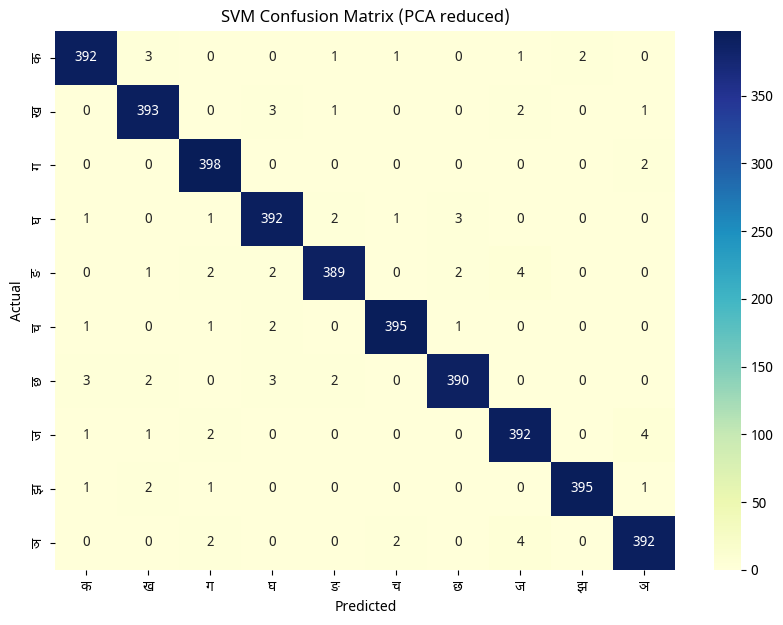

In [17]:
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix (PCA reduced)")
plt.show()

#  🎯 t-SNE 2D Visualization 

In [18]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_flat)

# 🖼️ Plot the t-SNE results

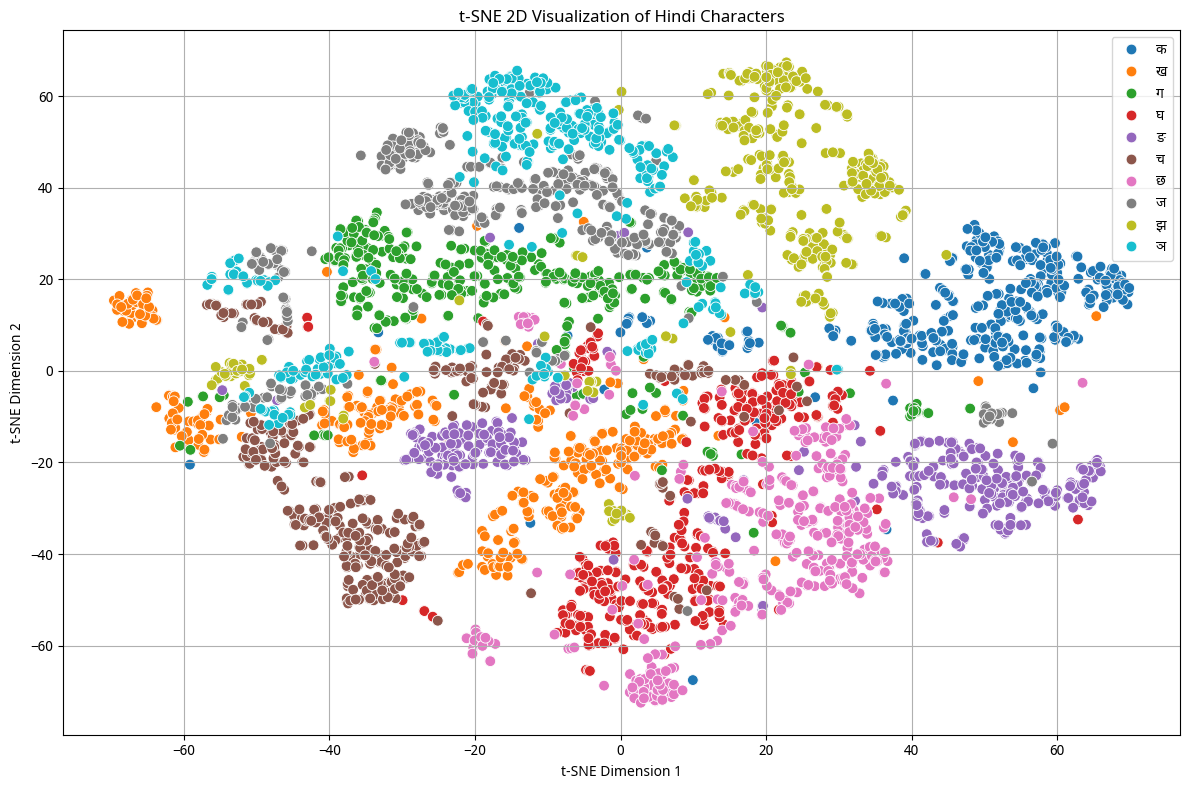

In [19]:
tsne_df = pd.DataFrame()
tsne_df['X'] = X_test_tsne[:, 0]
tsne_df['Y'] = X_test_tsne[:, 1]
tsne_df['Character'] = le.inverse_transform(y_test_encoded)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='X', y='Y', hue='Character', palette='tab10', s=60)
plt.title("t-SNE 2D Visualization of Hindi Characters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧠 Prepare Data for CNN

In [20]:
X_train_cnn = X_train_flat.reshape(-1, 32, 32, 1)
X_test_cnn = X_test_flat.reshape(-1, 32, 32, 1)

# 🔁 Data Augmentation

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train_cnn)

# 🧱 Build CNN Model

In [22]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=num_class, activation='softmax')
])

# Compile model with sparse categorical crossentropy since labels are integer encoded (not one-hot)
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🏋️ Train CNN Model

In [23]:
history = cnn_model.fit(
    datagen.flow(X_train_cnn, y_train_encoded, batch_size=32),
    epochs=20,
    validation_data=(X_test_cnn, y_test_encoded),
    verbose=2
)

Epoch 1/20
500/500 - 6s - loss: 0.7892 - accuracy: 0.7544 - val_loss: 0.3082 - val_accuracy: 0.8985 - 6s/epoch - 12ms/step
Epoch 2/20
500/500 - 4s - loss: 0.2501 - accuracy: 0.9210 - val_loss: 0.0391 - val_accuracy: 0.9885 - 4s/epoch - 8ms/step
Epoch 3/20
500/500 - 4s - loss: 0.1610 - accuracy: 0.9461 - val_loss: 0.0343 - val_accuracy: 0.9905 - 4s/epoch - 9ms/step
Epoch 4/20
500/500 - 4s - loss: 0.1401 - accuracy: 0.9572 - val_loss: 0.0365 - val_accuracy: 0.9902 - 4s/epoch - 9ms/step
Epoch 5/20
500/500 - 5s - loss: 0.1158 - accuracy: 0.9644 - val_loss: 0.0254 - val_accuracy: 0.9918 - 5s/epoch - 9ms/step
Epoch 6/20
500/500 - 4s - loss: 0.1039 - accuracy: 0.9694 - val_loss: 0.0176 - val_accuracy: 0.9942 - 4s/epoch - 9ms/step
Epoch 7/20
500/500 - 4s - loss: 0.0961 - accuracy: 0.9717 - val_loss: 0.0160 - val_accuracy: 0.9948 - 4s/epoch - 9ms/step
Epoch 8/20
500/500 - 5s - loss: 0.0974 - accuracy: 0.9710 - val_loss: 0.0128 - val_accuracy: 0.9952 - 5s/epoch - 10ms/step
Epoch 9/20
500/500 - 4

# 🎯 Evaluate CNN

CNN Test Accuracy: 1.00
125/125 [==============================] - 0s 2ms/step


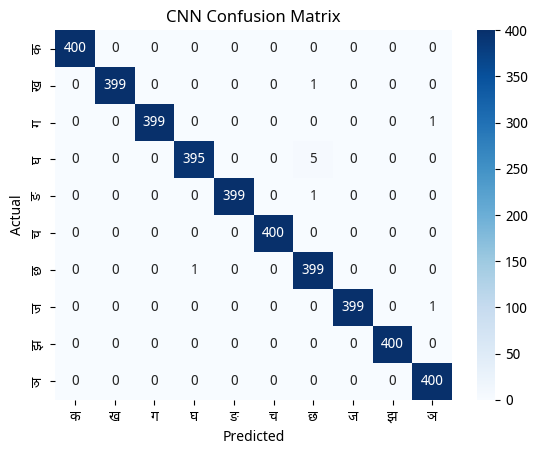

In [24]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_encoded, verbose=0)
print(f"CNN Test Accuracy: {test_acc:.2f}")
y_pred_cnn_prob = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)
cm_cnn = confusion_matrix(y_test_encoded, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()

# 💾 Save Model and Encoder

In [25]:
cnn_model.save("hindi_character_model.h5")
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
